In [22]:
import HTMLParser
import re
import itertools
import spacy
import nltk
from nltk.stem.snowball import SnowballStemmer
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import feature_extraction
import networkx as nx
import matplotlib.pyplot as plt
from nltk import Tree
import numpy as np
import timeit
import pandas as pd
from collections import Counter
from matplotlib import style
style.use("ggplot")
from mpl_toolkits.mplot3d import Axes3D
from pylab import *
from sklearn.cluster import KMeans
from __future__ import print_function

In [26]:
html_parser = HTMLParser.HTMLParser()

In [27]:
%time en_nlp = spacy.load('en')

In [20]:
def cleaning(original_tweet):
    tweet = html_parser.unescape(original_tweet)
    tweet = original_tweet.decode("utf8").encode('ascii','ignore')
    APPOSTOPHES = {"'s" : " is", "'re" : " are"}
    words = tweet.split()
    reformed = [APPOSTOPHES[word] if word in APPOSTOPHES else word for word in words]
    reformed = " ".join(reformed)
    cleaned = " ".join(re.findall('[A-Z][^A-Z]*', original_tweet))
    tweet = ''.join(''.join(s)[:2] for _, s in itertools.groupby(tweet))
    result = re.sub(r"http\S+", "", tweet)
    s = re.sub("\d+", "", result)
    line = re.sub('[!@#$>&<]', '',s)
    return line
    

In [57]:
class RatedWordgroup:
    def __init__(self,wordgroup,rating):
        self.wordgroup = wordgroup
        self.rating = rating

    def __str__(self):
        result = str(self.wordgroup) +" - " + str(self.rating)
        return result

    def __eq__(self,other):
        return self.wordgroup.eq(other.wordgroup) and self.rating.eq(other.rating)

    def __hash__(self):
        return hash(self.__str__())

In [58]:
class RatedSentence:

    def __init__(self,position,sentence,rating):
        self.position = position
        self.sentence = sentence
        self.rating = rating

    def __str__(self):
        result = "(" + str(self.position) +") (" + str(self.rating) +") " + self.sentence
        return result

    def __eq__(self,other):
        return self.position.eq(other.position) and self.sentence.eq(other.sentence) and self.rating.eq(other.rating)

    def __hash__(self):
        return hash(self.rating)

In [59]:
def get_word_bag(text) :
    text = text.lower()
    text = re.sub("[^a-ž]+", " ", text)
    text = re.sub("\n", " ", text)
    text = re.sub("[ ]+", " ", text)
    wordlist = text.split(" ")
    word_bag = list()
    for word in wordlist :
        word_bag.append(word.strip())
    return word_bag

In [60]:
def get_sentences(text,delimiter='.') :
    text = re.sub("\n", " ", text)
    text = re.sub("[ ]+", " ", text)
    sentences = text.split(delimiter)
    return sentences

In [61]:
def group_words(text) :
    word_bag = get_word_bag(text)

    cleanset = set()
    used_words = set()
    word_groups = list()

    for word in word_bag :
        cleanset.add(word.strip())

    for word in cleanset :
        if word not in used_words :
            wordfamily = list()
            wordfamily.append(word)
            if(len(word)>2) :
                used_words.add(word)
                for other in cleanset :
                    if other not in used_words :
                        same_chars = 0
                        (min_len,max_len) = (len(word),len(other)) if len(word) <= len(other) else (len(other),len(word))
                        for x in range(0,min_len) :
                            if word[x] == other[x] :
                                same_chars += 1
                            else :
                                break
                        if same_chars > 3 and (max_len - same_chars) < 7 :
                            wordfamily.append(other)
                            used_words.add(other)
            word_groups.append(wordfamily)
    return word_groups

In [62]:
def get_wordlist_rate(text) :
    word_groups = group_words(text)
    word_bag = get_word_bag(text)
    rated_word_set = set()
    for group in word_groups :
        occur = 0
        for word in group :
            occur += word_bag.count(word)
        rated_word_set.add(RatedWordgroup(group,occur))
    return rated_word_set

In [63]:
def rate_sentences(text,percentage=10,verbose=True) :
    result = str()
    sentences = get_sentences(text)
    wordlist = get_wordlist_rate(text)
    rated = list()
    topwords = list()
    sort_wg = sorted(wordlist, key = lambda group : group.rating, reverse=True)
    for rwg in sort_wg:
        if rwg.rating > 1 and len(rwg.wordgroup[0]) > 4 :
            #and len(rwg.wordgroup) > 1:
            weight = 1
            weight += rwg.rating/2
            weight += len(rwg.wordgroup[0])/2
            weight += len(rwg.wordgroup)/1
            for word in rwg.wordgroup :
                topwords.append((weight,word))
    position = 0
    for sentence in sentences :
        rating = 0
        position += 1
        bag = get_word_bag(sentence)
        for word in bag :
            for record in topwords :
                 if word.lower()==record[1]:
                    rating += record[0]
        if(rating>0 and len(bag) > 0):
            if((len(bag)/7) !=0):
                rating = rating/((len(bag))/7)
            else:
                rating=0

        rated_sentence = RatedSentence(position, sentence, rating)

        rated.append(rated_sentence)

    sort_sentences = sorted(rated, key = lambda sen : sen.rating, reverse=True)
    num_of_sen = int((len(sentences) / 100.0) * percentage)
    unsorted_result = list()

    counter = 0
    for rs in sort_sentences:
        if(counter>num_of_sen):
            break
        else:
            unsorted_result.append(rs)
            counter += 1

    sort_result = sorted(unsorted_result, key = lambda sen : sen.position, reverse=False)

    for rs in sort_result:
        result += rs.sentence + "."

    return result

In [12]:
synopses_wiki = open('synopses_list_wiki.txt').read().split('\n BREAKS HERE')
print("Number of synopsis  ----")
len(synopses_wiki)

Number of synopsis  ----


101

In [13]:
synopses_wiki = synopses_wiki[:100]

In [28]:
suma=[]
start_time = timeit.default_timer()

for i in synopses_wiki:
    suma.append(cleaning(i))
clean = timeit.default_timer() - start_time
print clean

1.51742033702


In [68]:
sumar=[]
start_time = timeit.default_timer()
for i in suma:
    get_sentences(i)
    get_wordlist_rate(i)
    sumar.append(rate_sentences(i))
summarize = timeit.default_timer() - start_time
print summarize

38.1765998345


In [69]:
from nltk.corpus import stopwords
def stopword_removal(text1):
    tex=text1.split()
    text = ' '.join([word for word in tex if word not in stopwords.words('english')])
    return text

In [70]:
stopsum=[]
start_time = timeit.default_timer()
for i in sumar:
    stopsum.append(stopword_removal(i))
stopwordremoval = timeit.default_timer() - start_time
print stopwordremoval

4.57152637757


In [71]:
stemmer = SnowballStemmer("english")

In [72]:
def tokenize_and_stem(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [73]:
ts=[]
tj=[]
sum=[]
start_time = timeit.default_timer()
for i in stopsum:
    ts.append(tokenize_and_stem(i))
    
for i in ts:
    tj.append(' '.join(i))
tokenstem = timeit.default_timer() - start_time
print tokenstem  

1.07507980731


In [74]:
doc=[]
for i in tj:
    doc.append(en_nlp(i.decode('utf-8')))

In [75]:
class Matgra:
    
    def __init__(self, dc,a):
        self.dG=a
        self.doc=dc
        
    def to_nod(self,node):
        if not self.dG.has_node(node):
            self.dG.add_node(node)
        if node.n_lefts + node.n_rights > 0:
            for child in node.children:
                self.dG.add_edge(node,child)
                self.to_nod(child)
        
    def to_send(self):
        [self.to_nod(sent.root) for sent in self.doc.sents]
        
    def to_res(self):
        self.to_send()
        a=nx.to_numpy_matrix(self.dG)
        return a

In [82]:
res=[]
start_time = timeit.default_timer()
for i in doc:
    dG = nx.DiGraph()
    b=Matgra(i,dG)
    res.append(b.to_res())
graphconvert = timeit.default_timer() - start_time
print graphconvert    

0.0846716514607


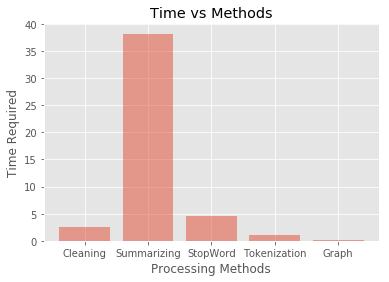

In [83]:
objects = ('Cleaning', 'Summarizing', 'StopWord', 'Tokenization', 'Graph')
y_pos = np.arange(len(objects))
performance = [clean,summarize,stopwordremoval,tokenstem,graphconvert]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Time Required')
plt.xlabel('Processing Methods')
plt.title('Time vs Methods')
 
plt.show()

In [84]:
class Graph:
    s=0
    def __init__(self, graph):
        self.graph = np.asarray(graph)
        self.graphSize = graph.shape[0]
        s=graph.shape[0]
        self.nodeList=[]
        self.inDegreeNodeList = [[] for _ in range(s)]
        self.outDegreeNodeList = [[] for _ in range(s)]
     
    def setInDegreeNodeList(self):
        for i in range(0, self.graphSize):
            for j in range(0, self.graphSize):
                if self.graph[i][j] != 0:
                    self.inDegreeNodeList[j].append(i)
    
            
    def setOutDegreeNodeList(self): 
        for i in range(0, self.graphSize):
            for j in range(0, self.graphSize):
                if self.graph[i][j] != 0:
                    self.outDegreeNodeList[i].append(j)
            
    def getGraph(self):
        return self.graph

    def getGraphSize(self):
        return self.graphSize

    def getInDegreeNodeList(self):
        self.setInDegreeNodeList()
        return self.inDegreeNodeList

    def getOutDegreeNodeList(self):
        self.setOutDegreeNodeList()
        return self.outDegreeNodeList
    
    def setNodeList(self):
        i = 0
        while i < self.graphSize: 
            self.nodeList.append(i)
            i += 1
            
    def getNodeList(self):
        self.setNodeList()
        return self.nodeList

In [86]:
gr=[]
for i in res:
    gr.append(Graph(i))

In [88]:
class NMSimilarity():
    ga=0
    gb=0
    def __init__(self, graphA, graphB, epsilon):
        self.graphA = graphA
        self.graphB = graphB
        self.epsilon = epsilon
        self.inNodeListA = graphA.getInDegreeNodeList()
        self.outNodeListA = graphA.getOutDegreeNodeList()
        self.inNodeListB = graphB.getInDegreeNodeList()
        self.outNodeListB = graphB.getOutDegreeNodeList()
        self.graphSizeA = graphA.getGraphSize()
        ga=graphA.getGraphSize()
        self.graphSizeB = graphB.getGraphSize()
        gb=graphB.getGraphSize()
        self.nodeSimilarity = [[0 for x in range(ga)] for y in range(gb)]
        self.inNodeSimilarity = [[0 for x in range(ga)] for y in range(gb)]
        self.outNodeSimilarity = [[0 for x in range(ga)] for y in range(gb)]
        
        
    def initializeSimilarityMatrices(self):
        for i in range(0,self.graphSizeA):
            for j in range(0,self.graphSizeB):
                maxDegree = float(max(len(self.inNodeListA[i]),len(self.inNodeListB[j])))
                if maxDegree != 0:
                    self.inNodeSimilarity[i][j] = ((min(len(self.inNodeListA[i]), len(self.inNodeListB[j]))) / (maxDegree))
                else:
                    self.inNodeSimilarity[i][j] = float(0.0)


                maxDegree = float(max(len(self.outNodeListA[i]), len(self.outNodeListB[j])));
                if maxDegree != 0:
                    self.outNodeSimilarity[i][j] = ((min(len(self.outNodeListA[i]), len(self.outNodeListB[j]))) / (maxDegree))
                else:
                    self.outNodeSimilarity[i][j] = float(0.0)

        for i in range(0,self.graphSizeA):
            for j in range(0,self.graphSizeB) :
                self.nodeSimilarity[i][j] = (self.inNodeSimilarity[i][j] + self.outNodeSimilarity[i][j])
        
    def enumerationFunction(self, neighborListMin, neighborListMax, graph):
        similaritySum = 0.0
        valueMap = {}
        if graph == 0:
            l1=len(neighborListMin)
            for i in range(0,l1):
                node=neighborListMin[i]
                maxi=0.0
                maxIndex=-1
                l2=len(neighborListMax)
                for j in range(0,l2):
                    key=neighborListMax[j]
                    if key not in valueMap:
                        try:
                            if maxi < self.nodeSimilarity[node][key]:
                                maxi = self.nodeSimilarity[node][key]
                                maxIndex = key
                        except IndexError:
                            pass
                        continue
                valueMap[maxIndex]=maxi
        else:
            for i in range(len(neighborListMin)):
                node=neighborListMin[i]
                maxi=0.0
                maxIndex=-1
                for j in range(len(neighborListMax)):
                    key=neighborListMax[j]
                    if key not in valueMap:
                        try:
                            if maxi < self.nodeSimilarity[key][node]:
                                maxi = self.nodeSimilarity[key][node]
                                maxIndex = key
                        except IndexError:
                            pass
                        continue
                valueMap[maxIndex]=maxi
        valu=0.0       
        for val in valueMap.itervalues():
            valu=valu+float(val)
        similaritySum=valu
        return similaritySum
        
        
    def measureSimilarity(self):
        maxDifference = 0.0
        terminate = False
        while not terminate:
            maxDifference = 0.0
            for i in range(0, self.graphSizeA):
                for j in range(0, self.graphSizeB):
                    similaritySum = 0.0
                    try:
                        maxDegree = float(max(len(self.inNodeListA[i]), len(self.inNodeListB[j])))
                        minDegree = int(min(len(self.inNodeListA[i]), len(self.inNodeListB[j])))
                        # calculate in-degree similarities
                        if minDegree == len(self.inNodeListA[i]):
                            similaritySum = self.enumerationFunction(self.inNodeListA[i], self.inNodeListB[j], 0)
                        else:
                            similaritySum = self.enumerationFunction(self.inNodeListB[j], self.inNodeListA[i], 1)
                        if maxDegree == 0.0 and similaritySum == 0.0:
                            self.inNodeSimilarity[i][j] = 1.0
                        elif maxDegree == 0.0:
                            self.inNodeSimilarity[i][j] = 0.0
                        else:

                            self.inNodeSimilarity[i][j]=float(similaritySum / maxDegree)
                    except IndexError:
                        pass
                    continue
                    similaritySum = 0.0
                    try:
                        maxDegree = float(max(len(self.outNodeListA[i]), len(self.outNodeListB[j])));
                        minDegree = int(min(len(self.outNodeListA[i]), len(self.outNodeListB[j])));
                        if minDegree == len(self.outNodeListA[i]):
                            similaritySum = self.enumerationFunction(self.outNodeListA[i], self.outNodeListB[j], 0)
                        else:
                            similaritySum = self.enumerationFunction(self.outNodeListB[j], self.outNodeListA[i], 1)
                        if maxDegree == 0.0 and similaritySum == 0.0:
                            self.outNodeSimilarity[i][j] = 1.0
                        elif maxDegree == 0.0:
                            self.outNodeSimilarity[i][j] = 0.0
                        else:
                            self.outNodeSimilarity[i][j] = similaritySum / maxDegree
                    except IndexError:
                        pass
                    continue


            for i in range(0,self.graphSizeA):
                for j in range(0,self.graphSizeB):
                    try:
                        temp = (self.inNodeSimilarity[i][j] +self.outNodeSimilarity[i][j]);
                        if abs(self.nodeSimilarity[i][j] - temp) > maxDifference:
                            maxDifference = abs(self.nodeSimilarity[i][j] - temp)
                        self.nodeSimilarity[i][j] = temp
                    except IndexError:
                        pass
                    continue


            if maxDifference < self.epsilon:
                terminate = True
 
    def getGraphSimilarity(self):
        finalGraphSimilarity = 0.0
        self.measureSimilarity()
        
        if self.graphA.getGraphSize() < self.graphB.getGraphSize():
            finalGraphSimilarity = self.enumerationFunction(self.graphA.getNodeList(), self.graphB.getNodeList(), 0) / self.graphA.getGraphSize()
        else:
            finalGraphSimilarity = self.enumerationFunction(self.graphB.getNodeList(), self.graphA.getNodeList(), 1) / self.graphB.getGraphSize()
        finalGraphSimilarity = float('{:f}'.format(finalGraphSimilarity * 100))
        return finalGraphSimilarity

In [91]:
nm=NMSimilarity(gr[34],gr[95],0.0001)
nm.getGraphSimilarity()

16.766827

In [92]:
int(round(nm.getGraphSimilarity()))

17

In [39]:
with open('1.txt', 'w') as target:
    for i in range (0,101):
        for j in range (0,101):
            nm=NMSimilarity(gr[i],gr[j],0.0001)
            a=int(nm.getGraphSimilarity())
            b=str(a)
            target.write(b+'\n')
        target.write('\n')

In [38]:
with open('1.txt','r') as f:
    aten=[x.strip().split('\t') for x in f]

In [4]:
cluster_num = 5
kmeans = KMeans(n_clusters=cluster_num)
kmeans.fit(aten)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
print labels

[2 3 1 3 2 2 2 3 1 2 2 0 0 4 1 2 2 4 0 4 2 1 4 0 2 0 0 1 0 2 4 2 1 1 2 3 0
 1 2 2 1 3 2 0 0 2 2 0 2 0 1 3 2 4 0 1 4 2 2 2 1 2 4 1 1 4 1 0 1 4 4 4 2 0
 1 3 3 1 1 2 3 2 0 4 1 1 2 0 0 1 3 3 0 2 2 0 0 3 4 2]


In [7]:
clusters = kmeans.labels_.tolist()

In [8]:
titles = open('title_list.txt').read().split('\n')
titles = titles[:100]

In [9]:
genres = open('genres_list.txt').read().split('\n')
genres = genres[:100]

In [42]:
ranks = []
dist = 1 - cosine_similarity(aten)
for i in range(0,len(titles)):
    ranks.append(i)

In [16]:
films = { 'title': titles, 'rank': ranks, 'synopsis': synopses_wiki, 'cluster': clusters, 'genre': genres }
frame = pd.DataFrame(films, index = [clusters] , columns = ['rank', 'title', 'cluster', 'genre'])

In [17]:
grouped = frame['rank'].groupby(frame['cluster'])
grouped.mean()

cluster
0    52.190476
1    51.227273
2    43.612903
3    53.916667
4    52.000000
Name: rank, dtype: float64

In [31]:
print("Top terms per cluster:")
print()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
for i in range(5):
    print()
    print("Cluster %d titles:" % i, end='')
    for title in frame.ix[i]['title'].values.tolist():
        print(' %s,' % title, end='')
    print()
    print()

Top terms per cluster:


Cluster 0 titles: The Godfather: Part II, Psycho, West Side Story, Chinatown, Singin' in the Rain, It's a Wonderful Life, 12 Angry Men, Saving Private Ryan, An American in Paris, The Best Years of Our Lives, Doctor Zhivago, Jaws, The Apartment, A Place in the Sun, Good Will Hunting, Network, The African Queen, Stagecoach, Taxi Driver, Rebel Without a Cause, Rear Window,


Cluster 1 titles: Schindler's List, The Wizard of Oz, Vertigo, 2001: A Space Odyssey, Some Like It Hot, Gandhi, The Lord of the Rings: The Return of the King, Unforgiven, A Streetcar Named Desire, Braveheart, Platoon, The Exorcist, The French Connection, City Lights, It Happened One Night, Midnight Cowboy, Terms of Endearment, Giant, The Grapes of Wrath, The Graduate, American Graffiti, Mutiny on the Bounty,


Cluster 2 titles: The Godfather, Casablanca, One Flew Over the Cuckoo's Nest, Gone with the Wind, Titanic, Lawrence of Arabia, On the Waterfront, Forrest Gump, E.T. the Extra-Terrestrial

In [33]:
frame['Rank'] = frame['rank'] + 1
frame['Title'] = frame['title']

In [43]:
import os 
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.manifold import MDS
MDS()
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist) 
xs, ys = pos[:, 0], pos[:, 1]

In [44]:
from nltk.tag import pos_tag
def strip_proppers_POS(text):
    tagged = pos_tag(text.split())
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

In [49]:
cluster_colors = {0: '#E74C3C', 1: '#AF7AC5', 2: '#17A589', 3: '#F1C40F', 4: '#6E2C00'}
cluster_names = {0: 'Family, home, war', 
                 1: 'Police, killed, murders', 
                 2: 'Father, New York, brothers', 
                 3: 'Dance, singing, love', 
                 4: 'Killed, soldiers, captain'}

In [47]:
%matplotlib inline

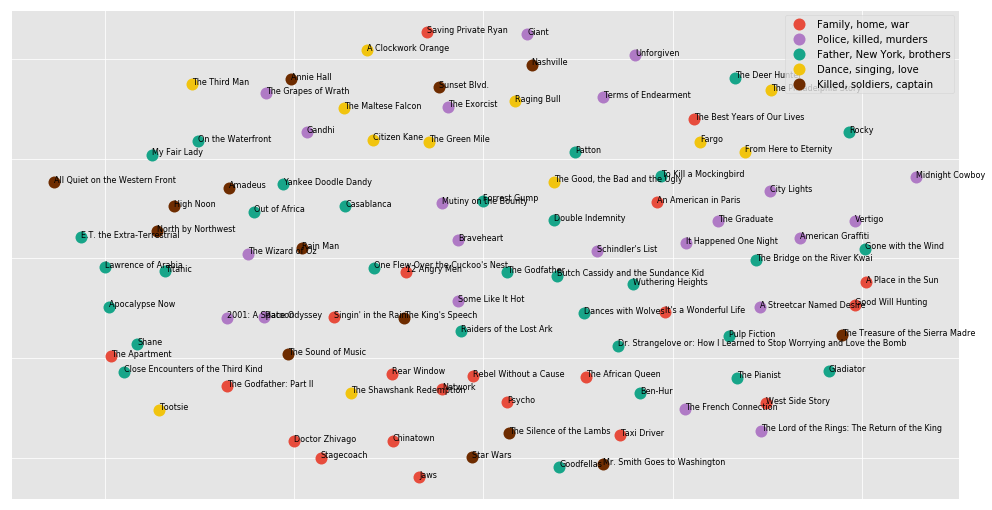

In [53]:
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(17,9)) 
ax.margins(0.05) 
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',  
        which='both',   
        bottom='off',      
        top='off',         
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',      
        which='both',   
        left='off',      
        top='off',         
        labelleft='off')
    
ax.legend(numpoints=1) 
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  
plt.show() 
plt.savefig('clustersdig.png', dpi=200)

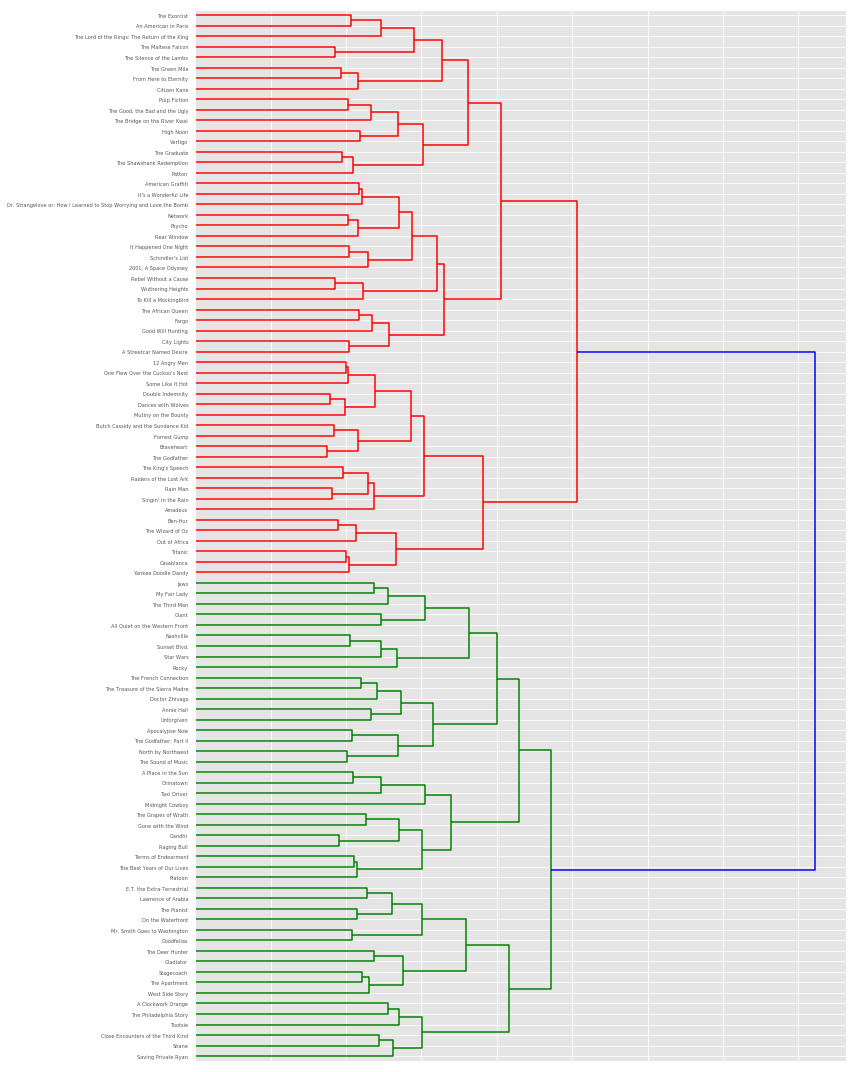

In [57]:
linkage_matrix = ward(dist)
fig, ax = plt.subplots(figsize=(12, 15)) 
ax = dendrogram(linkage_matrix, orientation="right", labels=titles);
plt.tick_params(\
    axis= 'x',    
    which='both',    
    bottom='off',     
    top='off', 
    labelbottom='off')

plt.tight_layout() 
plt.savefig('hierac_clusters.png', dpi=200)